In [1]:
import re
import json

In [3]:
with open('data/Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('data/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 21349

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
10865     2862258        21349             8228   
17482     1482516        21349             8228   
17600     1456923        21349             8228   
19427      705023        21349             8228   
28837     1317342        21349             8494   

                                                   title  year  \
10865  An adaptive beam control technique for diversi...  2016   
17482  Compressive sensing analysis of Synthetic Aper...  2012   
17600  Target identification in foliage environment u...  2013   
19427  Application of the extraction of the image fea...  2013   
28837  Ground penetrating radar image enhancement usi...  2013   

                                                abstract  
10865  The earth observation missions have improved i...  
17482  This work addresses the use of compressive sen...  
17600  In this paper, a novel method of target identi...  
19427  In the application of the image mosaic, SIFT a...  
28837  Singular value decomposition and Fuzzy C-Means...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

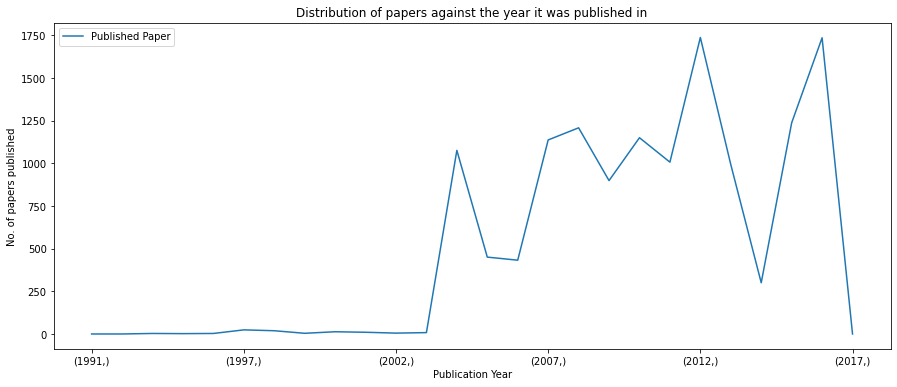

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2002 with year 2012 accounting for the highest number of papers.

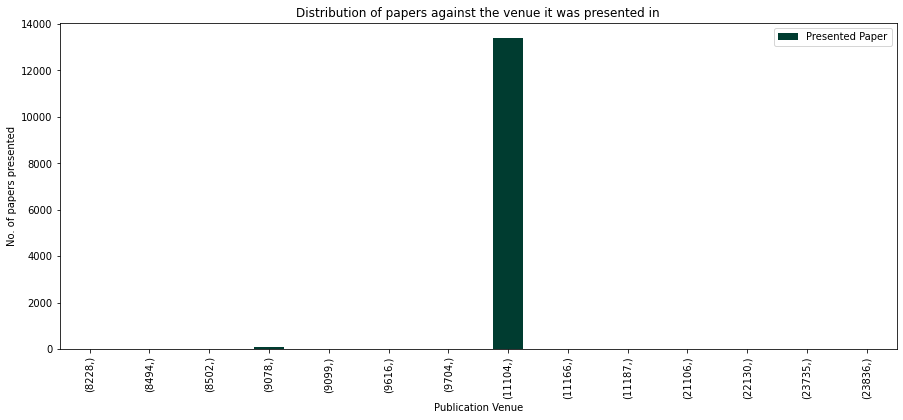

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [13]:
conference_data_dict[11104]

'international geoscience and remote sensing symposium'

One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 11104 which corresponds to the **International Geoscience and Remote Sensing Symposium Conference**, Hence most of the papers in the community are from that conference.

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

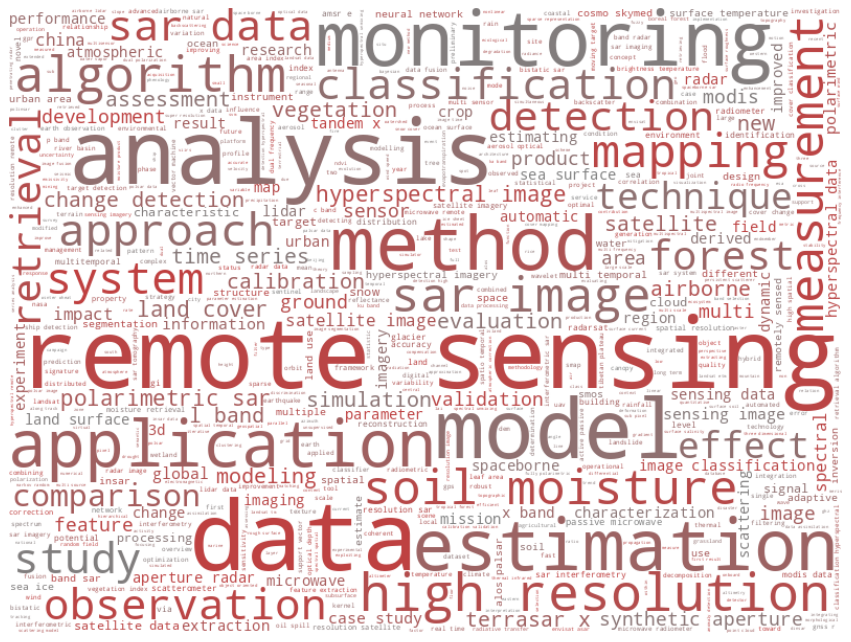

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, we can see that a lot of papers of the community focus on estimations, models and remote sensing. Since most papers of the community were presented at a conference about remote sensing, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

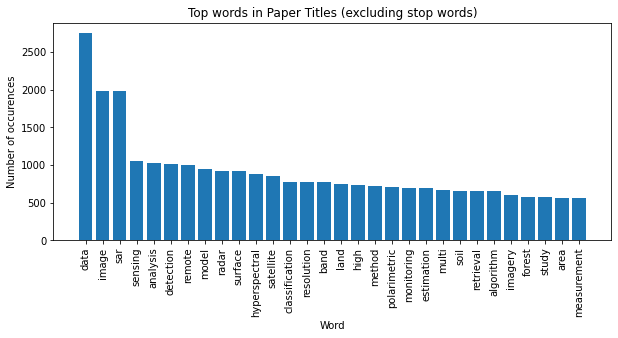

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are data, image, sar, sensing, analysing and so on. Considering most papers are about remote sensing and geo spatial data, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.035*"sar" + 0.028*"hyperspectral" + 0.024*"image" + 0.017*"data" + 0.015*"ice" + 0.014*"analysis"'),
 (1,
  '0.039*"sensing" + 0.038*"image" + 0.037*"remote" + 0.034*"data" + 0.028*"classification" + 0.023*"hyperspectral"'),
 (2,
  '0.046*"image" + 0.045*"sar" + 0.033*"resolution" + 0.032*"high" + 0.031*"detection" + 0.020*"radar"'),
 (3,
  '0.022*"x" + 0.020*"surface" + 0.017*"data" + 0.016*"sea" + 0.015*"band" + 0.015*"measurement"'),
 (4,
  '0.042*"soil" + 0.033*"moisture" + 0.032*"band" + 0.026*"sar" + 0.023*"retrieval" + 0.021*"data"'),
 (5,
  '0.032*"land" + 0.026*"data" + 0.026*"cover" + 0.017*"change" + 0.017*"china" + 0.017*"temporal"'),
 (6,
  '0.035*"microwave" + 0.019*"snow" + 0.017*"surface" + 0.015*"data" + 0.014*"temperature" + 0.014*"radiometer"'),
 (7,
  '0.030*"data" + 0.016*"modis" + 0.015*"time" + 0.013*"sensor" + 0.013*"index" + 0.012*"monitoring"'),
 (8,
  '0.028*"data" + 0.025*"monitoring" + 0.022*"sar" + 0.016*"2" + 0.015*"cosmo" + 0.015*"skymed"'),
 (

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

sar  hyperspectral     image      data       ice  analysis  \
0  0.034800       0.027799  0.024195  0.017170  0.014606  0.014007   
1  0.000000       0.023223  0.037931  0.034116  0.000000  0.007876   
2  0.044832       0.000000  0.046017  0.008072  0.000000  0.007121   
3  0.011667       0.000000  0.000000  0.016945  0.000000  0.000000   
4  0.026282       0.000000  0.007338  0.020765  0.000000  0.000000   
5  0.000000       0.000000  0.000000  0.026010  0.000000  0.015470   
6  0.000000       0.000000  0.000000  0.015186  0.000000  0.000000   
7  0.000000       0.000000  0.000000  0.029731  0.000000  0.008755   
8  0.021519       0.000000  0.010437  0.028422  0.000000  0.008623   
9  0.019621       0.000000  0.006925  0.035707  0.000000  0.013849   

   processing  algorithm    sparse  unmixing  ...      crop  decomposition  \
0    0.013921   0.013644  0.013344  0.013023  ...  0.000000       0.000000   
1    0.000000   0.008468  0.000000  0.000000  ...  0.000000       0.000000   
2    0.000000   0.009768  0.000000  0.000000  ...  0.000000       0.000000   
3    0.000000   0.000000  0.000000  0.000000  ...  0.000000       0.000000   
4    0.000000   0.000000  0.000000  0.000000  ...  0.000000       0.000000   
5    0.000000   0.000000  0.000000  0.000000  ...  0.000000       0.000000   
6    0.000000   0.000000  0.000000  0.000000  ...  0.000000       0.000000   
7    0.000000   0.000000  0.000000  0.000000  ...  0.000000       0.000000   
8    0.000000   0.000000  0.000000  0.000000  ...  0.000000       0.000000   
9    0.000000   0.000000  0.000000  0.000000  ...  0.009164       0.009151   

   scattering  polarization      dual     insar     wheat      full   envisat  \
0    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9    0.007911      0.007534  0.007216  0.006986  0.006507  0.006003  0.005881   

     angle  
0  0.00000  
1  0.00000  
2  0.00000  
3  0.00000  
4  0.00000  
5  0.00000  
6  0.00000  
7  0.00000  
8  0.00000  
9  0.00573  

[10 rows x 152 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


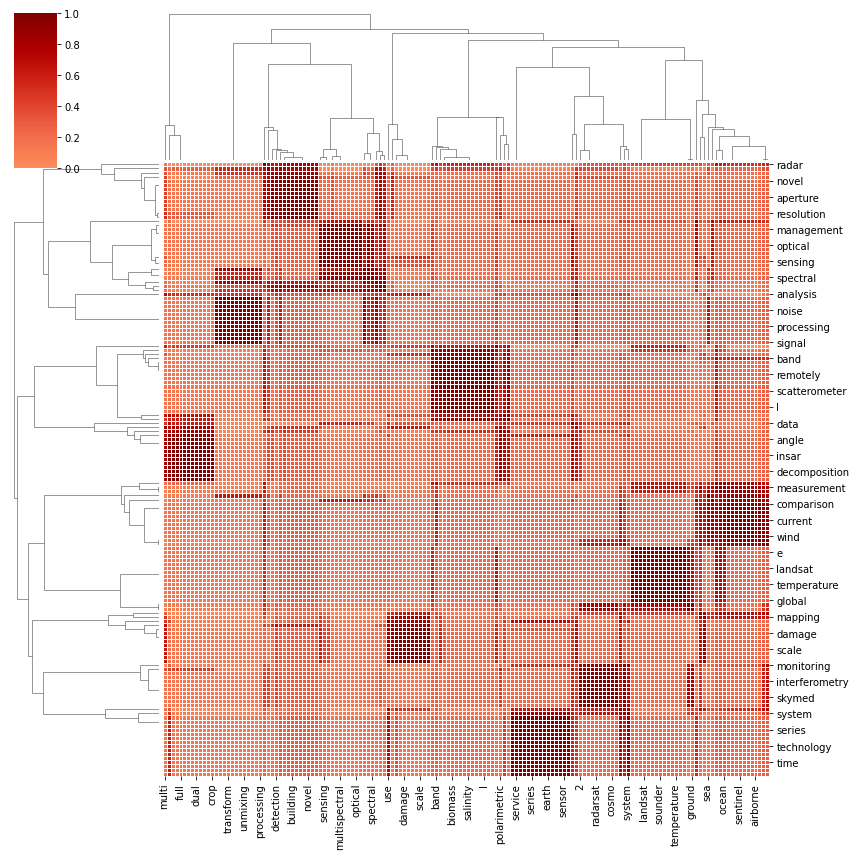

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  31.168202
2       0.648955  71.707100       2        1  18.728257
8      71.019684   9.971006       3        1  11.329161
4       3.785981  33.185135       4        1   8.533718
6     -42.666500  -9.222070       5        1   5.132478
0      -3.621689 -43.526516       6        1   5.023789
9      -3.632402  -4.171708       7        1   5.021611
3     -36.584400  35.804413       8        1   5.021231
5      44.391380  50.615383       9        1   5.020833
7      40.235809 -31.591665      10        1   5.020719, topic_info=              Term        Freq       Total Category  logprob  loglift
154            sar  226.000000  226.000000  Default  30.0000  30.0000
155           soil   56.000000   56.000000  Default  29.0000  29.0000
82   hyperspectral  137.000000  137.000000  Default  28.0000  28.0000
14            data  326.000000  326.000000  Default  27.0000  27.0000
514       moisture   41.000000   41.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
342            use    4.620014   30.454391  Topic10  -4.9861   1.1058
11        analysis    5.919954  106.504534  Topic10  -4.7381   0.1017
159     estimation    4.932427   58.200785  Topic10  -4.9206   0.5235
381           land    4.307113   56.849923  Topic10  -5.0562   0.4115
53         spatial    4.166967   74.702507  Topic10  -5.0893   0.1053

[756 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
619       2  0.092319       's
619       3  0.184638       's
619       4  0.092319       's
619       6  0.092319       's
619       8  0.184638       's
...     ...       ...      ...
656       7  0.043375        x
656       8  0.325314        x
656      10  0.065063        x
2809      6  1.126134  yangtze
903       7  0.789263    yield

[1453 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 9, 5, 7, 1, 10, 4, 6, 8])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  amplitude, board, tensor, extracting, need, discovery, french, topological, end, nearest, cryosphere, corrected, stepped, association, special

Paper Titles:
In memory of Professor Mikio Takagi
Maritime awareness for counter-piracy in the Gulf of Aden
Drill head mounted obstacle avoidance radar
Dayglow removal from FUV auroral images

****************************************************************************************************
TOPIC 1:
Top Words:  prism, dsm, separation, aboveground, standardization, rainforest, blind, singular, optimum, southwest, proposal, gauge, weed, query, tomosar

Paper Titles:
Near real time product of the gauge adjusted GSMaP (GSMaP_Gauge_NRT)
DSM generation with ALOS/PRISM data using SAT-PP
GIFTS SM EDU data processing and algorithms
Mapping the distribution of Crofton weed (Eupatorium adenophorum spreng) in southwest of China using time series remote sensing data

********************************************************************

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

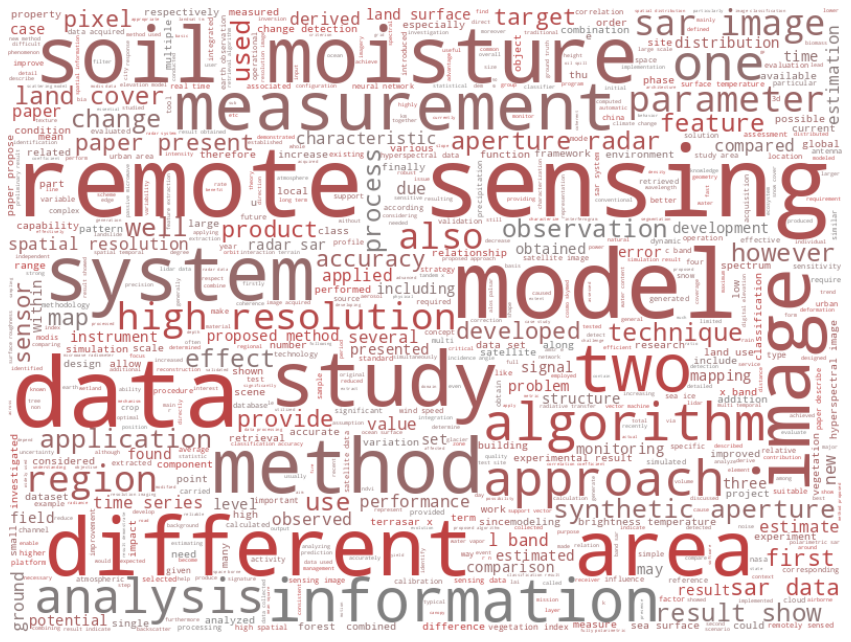

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.009*"model" + 0.008*"data" + 0.007*"parameter" + 0.006*"target" + 0.005*"effect" + 0.005*"method" + 0.005*"study"'),
 (1,
  '0.013*"data" + 0.010*"system" + 0.008*"r n" + 0.005*"application" + 0.004*"area" + 0.004*"monitoring" + 0.004*"change"'),
 (2,
  '0.014*"data" + 0.013*"model" + 0.006*"area" + 0.006*"water" + 0.006*"measurement" + 0.005*"study" + 0.005*"land surface"'),
 (3,
  '0.003*"south" + 0.003*"ati" + 0.002*"soil" + 0.002*"temperature" + 0.002*"global warming" + 0.002*"3d reconstruction" + 0.002*"shore"'),
 (4,
  '0.010*"image" + 0.009*"data" + 0.006*"area" + 0.006*"method" + 0.006*"forest" + 0.005*"land cover" + 0.005*"classification"'),
 (5,
  '0.011*"data" + 0.007*"change" + 0.006*"model" + 0.006*"method" + 0.006*"study" + 0.005*"analysis" + 0.004*"result"'),
 (6,
  '0.006*"model" + 0.006*"fire" + 0.004*"analysis" + 0.004*"system" + 0.003*"image" + 0.003*"data" + 0.003*"bistatic"'),
 (7,
  '0.011*"data" + 0.010*"product" + 0.010*"system" + 0.008*"satellite" + 0

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

model      data  parameter   target    effect    method     study  \
0  0.009013  0.008009   0.007136  0.00641  0.005212  0.005029  0.004755   
1  0.002720  0.013086   0.000000  0.00000  0.000000  0.000000  0.002773   
2  0.013288  0.014265   0.003579  0.00000  0.000000  0.003762  0.005391   
3  0.000000  0.001838   0.000000  0.00000  0.000000  0.000000  0.000000   
4  0.004236  0.008828   0.000000  0.00000  0.000000  0.005928  0.000000   
5  0.006295  0.010831   0.003083  0.00000  0.003127  0.006094  0.005714   
6  0.006154  0.002897   0.000000  0.00000  0.000000  0.000000  0.002591   
7  0.000000  0.010711   0.000000  0.00000  0.000000  0.000000  0.000000   
8  0.009506  0.014344   0.004210  0.00000  0.000000  0.000000  0.003733   
9  0.003959  0.018303   0.000000  0.00000  0.000000  0.013724  0.000000   

   analysis     paper    result  ...  presented    x band  measured  \
0  0.004345  0.004233  0.003958  ...    0.00000  0.000000  0.000000   
1  0.003124  0.000000  0.002918  ...    0.00000  0.000000  0.000000   
2  0.000000  0.000000  0.003501  ...    0.00000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  ...    0.00000  0.000000  0.000000   
4  0.003316  0.003256  0.003763  ...    0.00000  0.000000  0.000000   
5  0.004936  0.002810  0.004438  ...    0.00000  0.000000  0.000000   
6  0.004121  0.002347  0.001635  ...    0.00000  0.000000  0.000000   
7  0.000000  0.002266  0.000000  ...    0.00000  0.000000  0.000000   
8  0.000000  0.000000  0.004291  ...    0.00291  0.002738  0.002651   
9  0.004495  0.004925  0.005330  ...    0.00000  0.000000  0.000000   

   high resolution  technique  proposed  sar image   feature  resolution  \
0         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
1         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
2         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
3         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
4         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
5         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
6         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
7         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
8         0.000000   0.000000   0.00000   0.000000  0.000000    0.000000   
9         0.005182   0.004872   0.00451   0.003996  0.003867    0.003301   

        one  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.000000  
6  0.000000  
7  0.000000  
8  0.000000  
9  0.003131  

[10 rows x 131 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



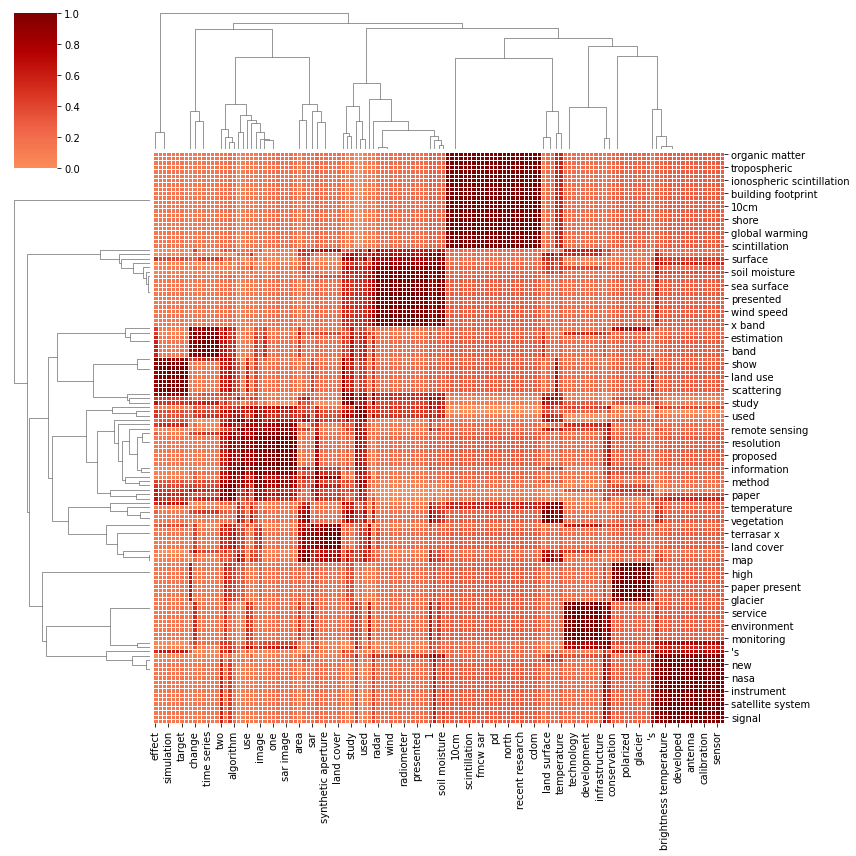

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  19.022736
1       0.648955  71.707100       2        1  18.757189
8      71.019684   9.971006       3        1  13.896887
9       3.785981  33.185135       4        1   9.373744
7     -42.666500  -9.222070       5        1   8.318039
5      -3.621689 -43.526516       6        1   8.282124
4      -3.632402  -4.171708       7        1   6.851505
0     -36.584400  35.804413       8        1   5.312664
6      44.391380  50.615383       9        1   5.095263
3      40.235809 -31.591665      10        1   5.089849, topic_info=                 Term       Freq       Total Category  logprob  loglift
185             image  51.000000   51.000000  Default  30.0000  30.0000
2517              r n  20.000000   20.000000  Default  29.0000  29.0000
2965    soil moisture  40.000000   40.000000  Default  28.0000  28.0000
25             method  48.000000   48.000000  Default  27.0000  27.0000
159             radar  34.000000   34.000000  Default  26.0000  26.0000
...               ...        ...         ...      ...      ...      ...
2030      temperature   1.592209   21.761917  Topic10  -6.0650   0.3629
21554          mobile   0.841110    1.420322  Topic10  -6.7032   2.4540
4409            grain   0.824993    1.265336  Topic10  -6.7225   2.5502
79               data   1.259745  160.761648  Topic10  -6.2992  -1.8711
1391   remote sensing   0.832340   37.280853  Topic10  -6.7137  -0.8241

[848 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1596      1  0.206078            's
1596      2  0.206078            's
1596      3  0.103039            's
1596      4  0.051519            's
1596      5  0.154558            's
...     ...       ...           ...
3166      3  0.079264          year
3166      5  0.079264          year
3166      6  0.079264          year
3166      7  0.079264          year
3397      9  1.046668  yellow river

[1301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 9, 10, 8, 6, 5, 1, 7, 4])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  autoencoder, ester, pme slick spread, pme, pme slick, autoencoder active learning, autoencoder active, canopy vertical parameter, biogenic sea slick, spread hexane, hexane, sea slick, biogenic sea, slick spread hexane, subsidence profile

Paper Titles:
Sea slicks and oil spills-the chemical structure and morphology determines the remote sensing signals
Stability assessment of high-speed railway using advanced InSAR technique
Active learning based autoencoder for hyperspectral imagery classification
Canopy vertical parameters estimation using unmanned aerial vehicle (UAV) imagery

****************************************************************************************************
TOPIC 1:
Top Words:  arroyo, irsn, graph grammar, slider, canutillo, chiayi, typhoon caused, chiayi county, paso, el paso, quadrilateral, quadrilateral primitive, autocorrelation sidelobes, aom, mowad st

Paper Titles:
How land use from remote sensing is very helpful for terrestrial radieco

For finding insights between different communites, we will extract a few paper data from this community which essentially belong to all the different topics generated by LDA for the community. Since the the community with id 21258 that has the lowest number of papers (about 3500), we will initially pick up about 3500 papers from each of the community and drop any duplicates from them and analyze inter community insights with the collected data with a fair distribution of papers from all the communites.

In [71]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [72]:
representative_df.to_csv("CSV_files/repr_21349.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
85631     1874654        21349            11104   
78324     2900992        21349            11104   
78360     2923201        21349            11104   
78418     2933659        21349            11104   
50234      898097        21349             9078   
...           ...          ...              ...   
78371     2923139        21349            11104   
78458     2933818        21349            11104   
78420     2969496        21349            11104   
91993      728255        21349            11104   
87975     1423632        21349            11104   

                                                   title  year  \
85631  Sea slicks and oil spills-the chemical structu...  2004   
78324  Stability assessment of high-speed railway usi...  2016   
78360  Active learning based autoencoder for hyperspe...  2016   
78418  Canopy vertical parameters estimation using un...  2016   
50234  Perceptron nonlinear blind source separation f...  2012   
...                                                  ...   ...   
78371  Feature extraction and classification of ocean...  2016   
78458  DAta simulation and fusion of imaging spectrom...  2016   
78420  Improving time series anomaly detection based ...  2016   
91993  Fusion of multitemporal and multiresolution re...  2014   
87975  New cascade model for hierarchical joint class...  2015   

                                                abstract  
85631  The different morphology of palmitic acid metl...  
78324  High-speed railways play important roles in co...  
78360  In this paper, we joint autoencoder with activ...  
78418  Canopy vertical parameters, such as tree heigh...  
50234  In this paper, we aim to classify remotely sen...  
...                                                  ...  
78371  The detection of ocean oil spill based on synt...  
78458  Multi-sensor systems are increasingly demandin...  
78420  Continuous anomaly detection in satellite imag...  
91993  In this paper, we propose a novel method to fu...  
87975  This paper addresses the problem of multisenso...  

[835 rows x 6 columns]